# Deep learning - Linear models 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, RNN

import warnings
warnings.filterwarnings('ignore')

2024-04-08 12:53:11.668178: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
plt.rcParams["figure.figsize"] = (9,6)

In [3]:
# Set seed
np.random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)

In [5]:
# Load data
train_df = pd.read_csv('data/train.csv')
val_df = pd.read_csv('data/val.csv')
test_df = pd.read_csv('data/test.csv')

In [6]:
# Check shape
print(train_df.shape)
train_df.head()

(12194, 11)


,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT,day_sin,day_cos,year_sin,year_cos
0,0.588227,0.454943,0.599461,0.473673,0.556576,0.613765,0.691018,-2.588190e-01,0.965926,0.021987,-0.999758
1,0.585130,0.459449,0.596738,0.471006,0.550279,0.620783,0.636233,-4.877283e-12,1.000000,0.021271,-0.999774
2,0.572743,0.436920,0.591319,0.465748,0.512595,0.586144,0.636233,2.588190e-01,0.965926,0.020554,-0.999789
3,0.571194,0.450437,0.591319,0.468414,0.515693,0.599955,0.581468,5.000000e-01,0.866025,0.019838,-0.999803
4,0.577388,0.450437,0.596738,0.473673,0.521990,0.599955,0.519656,7.071068e-01,0.707107,0.019121,-0.999817


In [8]:
# Function to create windows of data for training
def format_timeseries_data(df, input_length, output_length, target_names):

    # Condition
    if target_names is not None:

        # target indices
        target_indices = {name : i for i, name in enumerate(target_names)}
    
    # index for columns
    col_indices = {name : i for i, name in enumerate(df.columns)}

    # get total length
    total_length = input_length + output_length

    # slices of 
    input_slice = slice(0, input_length)
    output_slice = slice(input_length, None)

    # data
    data = np.array(df, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets = None,
        sequence_length=total_length,
        sequence_stride=1,
        shuffle=False,
        batch_size=32
    )

    # define function inside the function
    def split_to_input_output(x):

        inputs = x[:, input_slice, :]
        outputs = x[:, output_slice, :]

        if target_names is not None:

            outputs = tf.stack(
                [outputs[:, :, col_indices[name]] for name in target_names],
                axis=-1
            )
        
        inputs.set_shape([None, input_length, None])
        outputs.set_shape([None, output_length, None])

        return inputs, outputs
    
    ds = ds.map(split_to_input_output)

    return ds

In [14]:
# Function to train deep learning models
def train_model(model, train_ds, val_ds, patience = 5, max_epochs = 50):

    # early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, mode='min')

    model.compile(loss=MeanSquaredError(), optimizer=Adam(), metrics=[MeanAbsoluteError])

    # train model
    history = model.fit(train_ds, epochs=max_epochs, validation_data=val_ds, callbacks=[early_stopping])

    return history

In [15]:
MULL_max_train = 7.568999767303468
MULL_min_train = -5.934000015258789
MULL_max_test = 4.690999984741211
MULL_min_test = -3.3399999141693115

OT_max_train = 46.00699996948242
OT_min_train = -4.079999923706056
OT_max_test = 17.165000915527347
OT_min_test = 3.025000095367432

## Single-step model 

In [16]:
# Create a window of data with input length = 1 and output length = 1
train_ds_ss = format_timeseries_data(train_df, 1, 1, ['OT'])
val_ds_ss = format_timeseries_data(val_df, 1, 1, ['OT'])
test_ds_ss = format_timeseries_data(test_df, 1, 1, ['OT'])


# Store a sample batch to plot forecasts
ss_sample_batch = next(iter(test_ds_ss))

In [17]:
# Train a linear single-step model
ss_linear = Sequential([
    Dense(units=1)
])

ss_linear_history = train_model(ss_linear, train_ds_ss, val_ds_ss)

Epoch 1/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3172 - mean_absolute_error: 0.4481 - val_loss: 0.0554 - val_mean_absolute_error: 0.2001
Epoch 2/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0436 - mean_absolute_error: 0.1716 - val_loss: 0.0263 - val_mean_absolute_error: 0.1302
Epoch 3/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0270 - mean_absolute_error: 0.1293 - val_loss: 0.0264 - val_mean_absolute_error: 0.1284
Epoch 4/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0220 - mean_absolute_error: 0.1160 - val_loss: 0.0304 - val_mean_absolute_error: 0.1425
Epoch 5/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0173 - mean_absolute_error: 0.1034 - val_loss: 0.0303 - val_mean_absolute_error: 0.1438
Epoch 6/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0135 - mean_absolute_error: 0.0921 - val_loss: 0.0262 - val_mean_absolute_error: 0.1335
Epoch 7/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0111 - mean_absolute_error: 0.0840 - v

In [13]:
def plot_history(history):

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

    ax1.plot(history.history['loss'], label='Train')
    ax1.plot(history.history['val_loss'], label='Validation')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss')
    ax1.legend(loc='best')

    ax2.plot(history.history['mean_absolute_error'], label='Train')
    ax2.plot(history.history['val_mean_absolute_error'], label='Validation')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('MAE')
    ax2.set_title('Mean absolute error')
    ax2.legend(loc='best')

    plt.tight_layout()

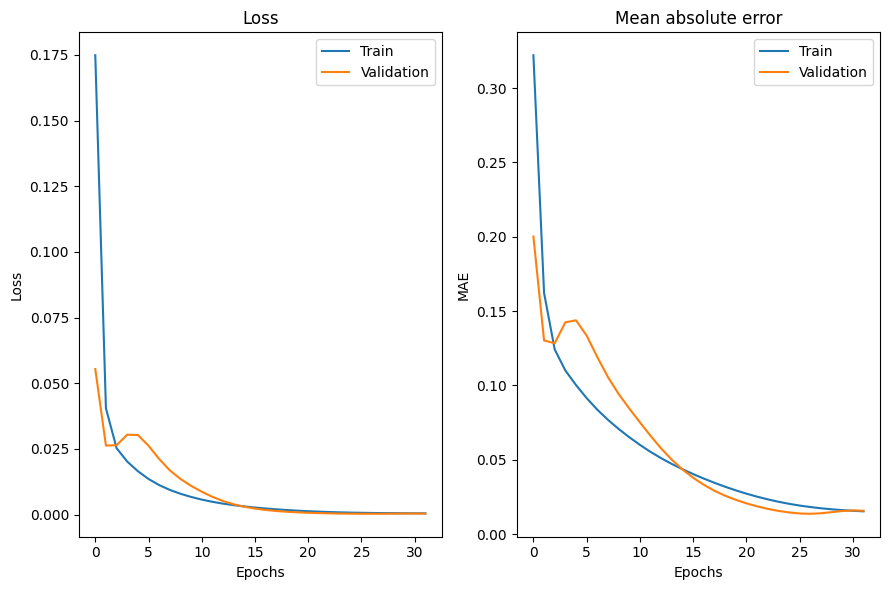

In [18]:
# Plot the loss and MAE
plot_history(ss_linear_history)

In [19]:
def plot_predictions(model, sample_batch, model_type):
    
    inputs, outputs = sample_batch
    preds = model(inputs)
    
    if model_type == 'single_step':      

        fig, ax = plt.subplots()
        
        # Inverse transform the min-max scaling
        actual_scaled = outputs.numpy().flatten()
        actual = actual_scaled * (OT_max_test - OT_min_test) + OT_min_test
        
        predictions_scaled = preds.numpy().flatten()
        predictions = predictions_scaled * (OT_max_train - OT_min_train) + OT_min_train

        ax.plot(actual, label='Actual')
        ax.plot(predictions, label='Predicted')
        ax.set_xlabel('Time steps')
        ax.set_ylabel('Oil temperature')
        ax.set_title('Predictions on a sample batch')
        ax.legend(loc='best')
        
    elif model_type == 'multi_step':

        fig, ax = plt.subplots()
        
        actual_scaled = outputs.numpy().flatten()[:48]
        actual = actual_scaled * (OT_max_test - OT_min_test) + OT_min_test
        
        predictions_scaled = preds.numpy().flatten()[:48]
        predictions = predictions_scaled * (OT_max_train - OT_min_train) + OT_min_train

        ax.plot(actual, label='Actual')
        ax.plot(predictions, label='Predicted')
        ax.set_xlabel('Time steps')
        ax.set_ylabel('Oil temperature')
        ax.set_title('Predictions on a sample batch')
        ax.legend(loc='best')
        
    elif model_type == 'multi_output':
        
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
        
        OT_actual_scaled = outputs.numpy().flatten()[0::2]
        OT_actual = OT_actual_scaled * (OT_max_test - OT_min_test) + OT_min_test
        
        OT_predictions_scaled = preds.numpy().flatten()[0::2]
        OT_predictions = OT_predictions_scaled * (OT_max_train - OT_min_train) + OT_min_train

        MULL_actual_scaled = outputs.numpy().flatten()[1::2]
        MULL_actual = MULL_actual_scaled * (MULL_max_test - MULL_min_test) + MULL_min_test
        
        MULL_predictions_scaled = preds.numpy().flatten()[1::2]
        MULL_predictions = MULL_predictions_scaled * (MULL_max_train - MULL_min_train) + MULL_min_train
        
        ax1.plot(OT_actual, label='Actual')
        ax1.plot(OT_predictions, label='Predicted')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Oil temperature')
        ax1.legend(loc='best')
        ax1.set_title('Predictions on a sample batch')
        
        ax2.plot(MULL_actual, label='Actual')
        ax2.plot(MULL_predictions, label='Predicted')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('MULL')
        ax2.legend(loc='best')
        
    plt.tight_layout()

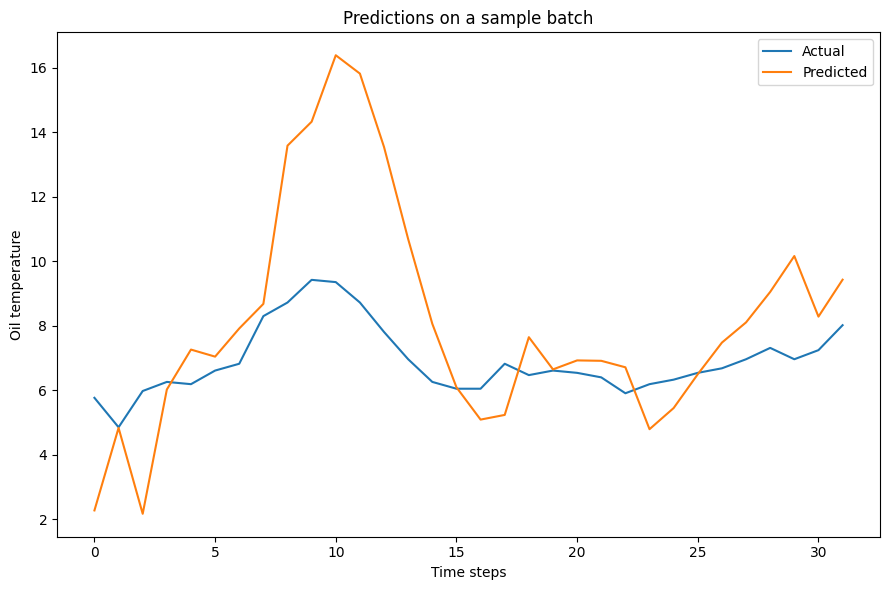

In [20]:
# Plot the predictions
plot_predictions(ss_linear, ss_sample_batch, 'single_step')

## Multi-step model 

In [21]:
# Create a window of input length = 24 and output length = 24
train_ds_ms = format_timeseries_data(train_df, 24, 24, ['OT'])
val_ds_ms = format_timeseries_data(val_df, 24, 24, ['OT'])
test_ds_ms = format_timeseries_data(test_df, 24, 24, ['OT'])

# Store a sample batch to plot the predictions
ms_sample_batch = next(iter(test_ds_ms))

In [22]:
# Create a linear multi-step model
ms_linear = Sequential([
    Dense(units=1)
])

ms_linear_history = train_model(ms_linear, train_ds_ms, val_ds_ms)

Epoch 1/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2467 - mean_absolute_error: 0.4020 - val_loss: 0.0973 - val_mean_absolute_error: 0.2591
Epoch 2/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1058 - mean_absolute_error: 0.2572 - val_loss: 0.0276 - val_mean_absolute_error: 0.1355
Epoch 3/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0696 - mean_absolute_error: 0.2012 - val_loss: 0.0141 - val_mean_absolute_error: 0.0940
Epoch 4/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0512 - mean_absolute_error: 0.1721 - val_loss: 0.0118 - val_mean_absolute_error: 0.0861
Epoch 5/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0406 - mean_absolute_error: 0.1536 - val_loss: 0.0126 - val_mean_absolute_error: 0.0906
Epoch 6/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0353 - mean_absolute_error: 0.1430 - val_loss: 0.0140 - val_mean_absolute_error: 0.0970
Epoch 7/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0330 - mean_absolute_error: 0.1382 - v

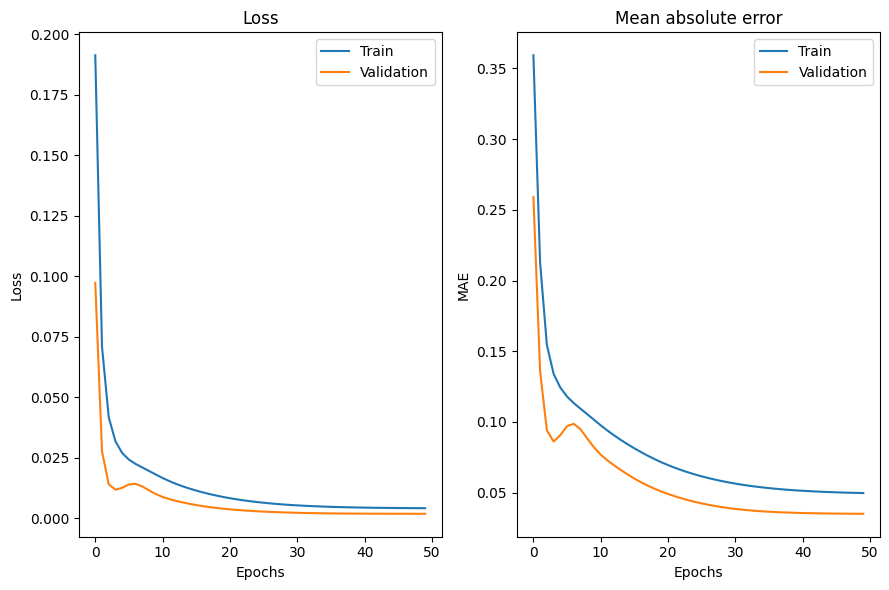

In [23]:
plot_history(ms_linear_history)

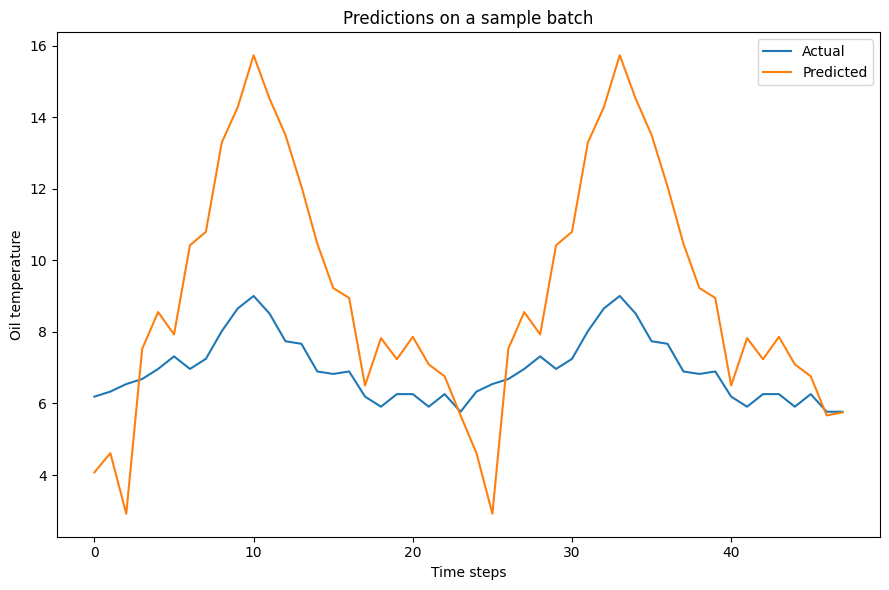

In [24]:
plot_predictions(ms_linear, ms_sample_batch, 'multi_step')

## Multi_output 

In [25]:
# Create a window of input length = 1 and output length = 1 to predict OT and MULL
train_ds_mo = format_timeseries_data(train_df, 1, 1, ['OT', 'MULL'])
val_ds_mo = format_timeseries_data(val_df, 1, 1, ['OT', 'MULL'])
test_ds_mo = format_timeseries_data(test_df, 1, 1, ['OT', 'MULL'])

mo_sample_batch = next(iter(test_ds_mo))

In [26]:
# Create a multi-output linear model
mo_linear = Sequential([
    Dense(units=2)
])

mo_linear_history = train_model(mo_linear, train_ds_mo, val_ds_mo)

Epoch 1/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1720 - mean_absolute_error: 0.3384 - val_loss: 0.1344 - val_mean_absolute_error: 0.2982
Epoch 2/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0297 - mean_absolute_error: 0.1396 - val_loss: 0.0468 - val_mean_absolute_error: 0.1588
Epoch 3/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0141 - mean_absolute_error: 0.0887 - val_loss: 0.0195 - val_mean_absolute_error: 0.1010
Epoch 4/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0123 - mean_absolute_error: 0.0815 - val_loss: 0.0122 - val_mean_absolute_error: 0.0811
Epoch 5/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0124 - mean_absolute_error: 0.0817 - val_loss: 0.0103 - val_mean_absolute_error: 0.0750
Epoch 6/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0126 - mean_absolute_error: 0.0815 - val_loss: 0.0099 - val_mean_absolute_error: 0.0734
Epoch 7/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0119 - mean_absolute_error: 0.0788 - v

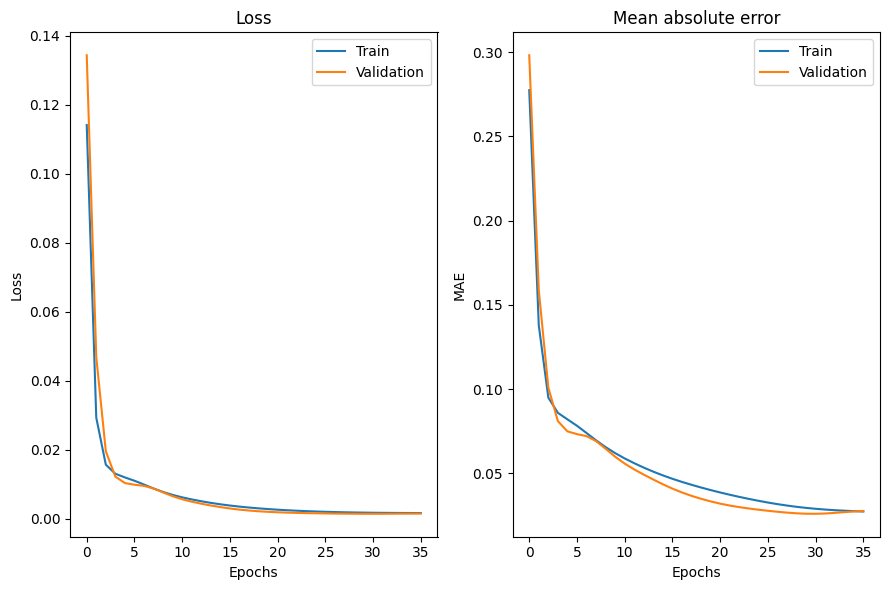

In [27]:
plot_history(mo_linear_history)

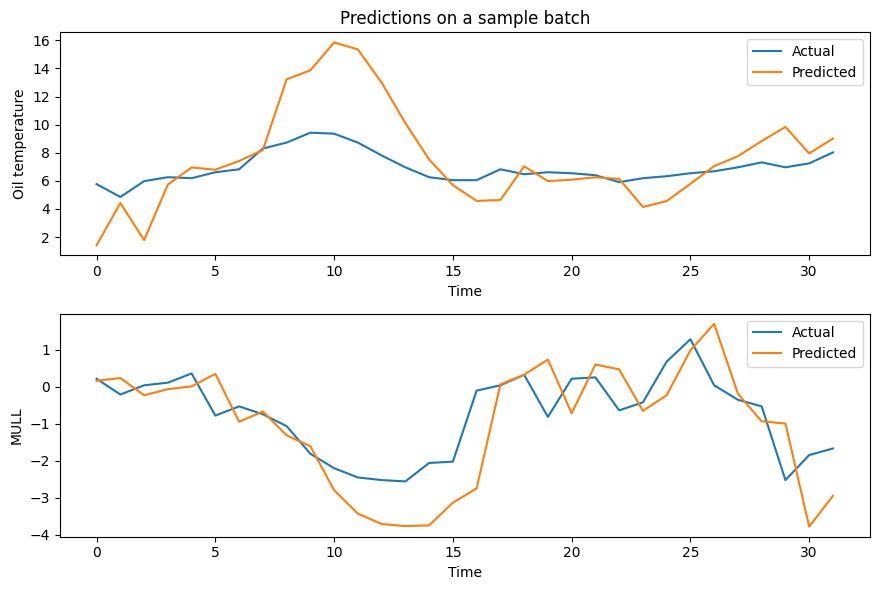

In [28]:
plot_predictions(mo_linear, mo_sample_batch, 'multi_output')

## Evaluation 

In [29]:
mae_linear_ss = ss_linear.evaluate(test_ds_ss)[1]
mae_linear_ms = ms_linear.evaluate(test_ds_ms)[1]
mae_linear_mo = mo_linear.evaluate(test_ds_mo)[1]

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0039 - mean_absolute_error: 0.0501
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0264 - mean_absolute_error: 0.1338
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0066 - mean_absolute_error: 0.0642
